In [1]:
import warnings
from typing import List, NoReturn, Tuple

import matplotlib.pyplot as plt
import torch
from pyannote.audio import Pipeline
import os

/Users/arsknz/miniforge3/envs/audio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline setup

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token="").to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


In [3]:
def fill_silence_intervals(data: List[Tuple[str, float, float]]) -> List[Tuple[str, float, float]]:
    """Fills missing intervals in the provided data with 'Silence'

    Args:
        data (List[Tuple[str, float, float]]): List of intervals where each entry consists of a speaker name, start time, and end time

    Returns:
        List[Tuple[str, float, float]]: Updated list of intervals with 'Silence' entries for gaps.
    """
    filled_data = []

    if data[0][1] > 0:
        filled_data.append(["Silence", 0, data[0][1]])
    for i, entry in enumerate(data):
        speaker, start, end = entry
        filled_data.append(entry)  

        
        if i < len(data) - 1:
            next_start = data[i + 1][1]
            if end < next_start: 
                filled_data.append(["Silence", end, next_start])
    return filled_data

In [4]:
def get_stat(file_name_of_lection: str) -> Tuple[
    List[Tuple[str, float]],
    List[Tuple[str, float, float]],
    object]:
    """Analyzes the audio file to calculate time allocation for lecturer, audience, and silence.

    Args:
        file_name_of_lection (str):  Path to the audio file of the lecture.

    Returns:
        Tuple[List[Tuple[str, float]], List[Tuple[str, float, float]], pyannote.core.annotation.Annotation]: 
        -Aggregated time data for lecturer, audience, and silence in seconds.
        -Detailed time intervals for each speaker and silence periods
        -The diarization result object that contains the speaker labels and their associated time segments.
    """

    diarization = pipeline(file=file_name_of_lection)

    time_allocation = diarization.chart()
    t_lecturer = time_allocation[0][1]
    t_audience = sum([time_allocation[i][1] for i in range(1, len(time_allocation))])
    t_silence = (
        max([segment.end for segment in diarization.itersegments()])
        - t_lecturer
        - t_audience
    )

    timestamps_of_speakers = []
    for segment, _, speaker in diarization.itertracks(yield_label=True):
        timestamps_of_speakers.append(
            [speaker, round(segment.start, 2), round(segment.end, 2)])

    lector_id = time_allocation[0][0]
    for i in range(len(timestamps_of_speakers)):
        if timestamps_of_speakers[i][0] == lector_id:
            timestamps_of_speakers[i][0] = "Lector"
        else:
            timestamps_of_speakers[i][0] = "Audience"

    return [["Lecturer", t_lecturer], ["Audience", t_audience], ["Silence", t_silence]], fill_silence_intervals(timestamps_of_speakers), diarization

In [ ]:
stat = get_stat("rec.mp3")

In [5]:
def graphics(statistic: Tuple[
    List[Tuple[str, float]],  
    List[Tuple[str, float, float]],  
    object]) -> None:
    """Plots graphical visualizations based on the provided statistic data.

    Args:
        statistic (Tuple[ List[Tuple[str, float]], List[Tuple[str, float, float]], object]): 
            -Aggregated time data for lecturer, audience, and silence in seconds.
            -Detailed time intervals for each speaker and silence periods
            -The diarization result object that contains the speaker labels and their associated time segments.
    
    Returns:
        NoReturn
    """

    fig, ax = plt.subplots()
    ax.pie(
        [item[1] for item in statistic[0]],
        labels=[item[0] for item in statistic[0]])
    ax.axis("equal")
    plt.show()

    speak = ["Lector", "Silence", "Audience"]
    fig, ax = plt.subplots(figsize=(32, 6))

    colors = plt.cm.tab10.colors  # Готовая палитра
    color_map = {speaker: colors[i % len(colors)] for i, speaker in enumerate(speak)}

    for speaker, start, end in statistic[-2]:
        ax.barh(
            y=speaker,
            width=end - start,
            left=start,
            color=color_map[speaker],
            edgecolor=None,
            height=0.4,
            label=speaker if speaker not in ax.get_legend_handles_labels()[1] else None)

    ax.set_xlabel("Время (секунды)")
    ax.set_title("Визуализация времени разговора")
    ax.legend(title="Спикеры", loc="upper right")
    ax.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

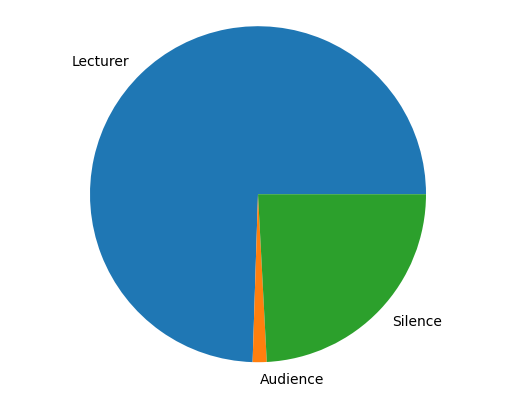

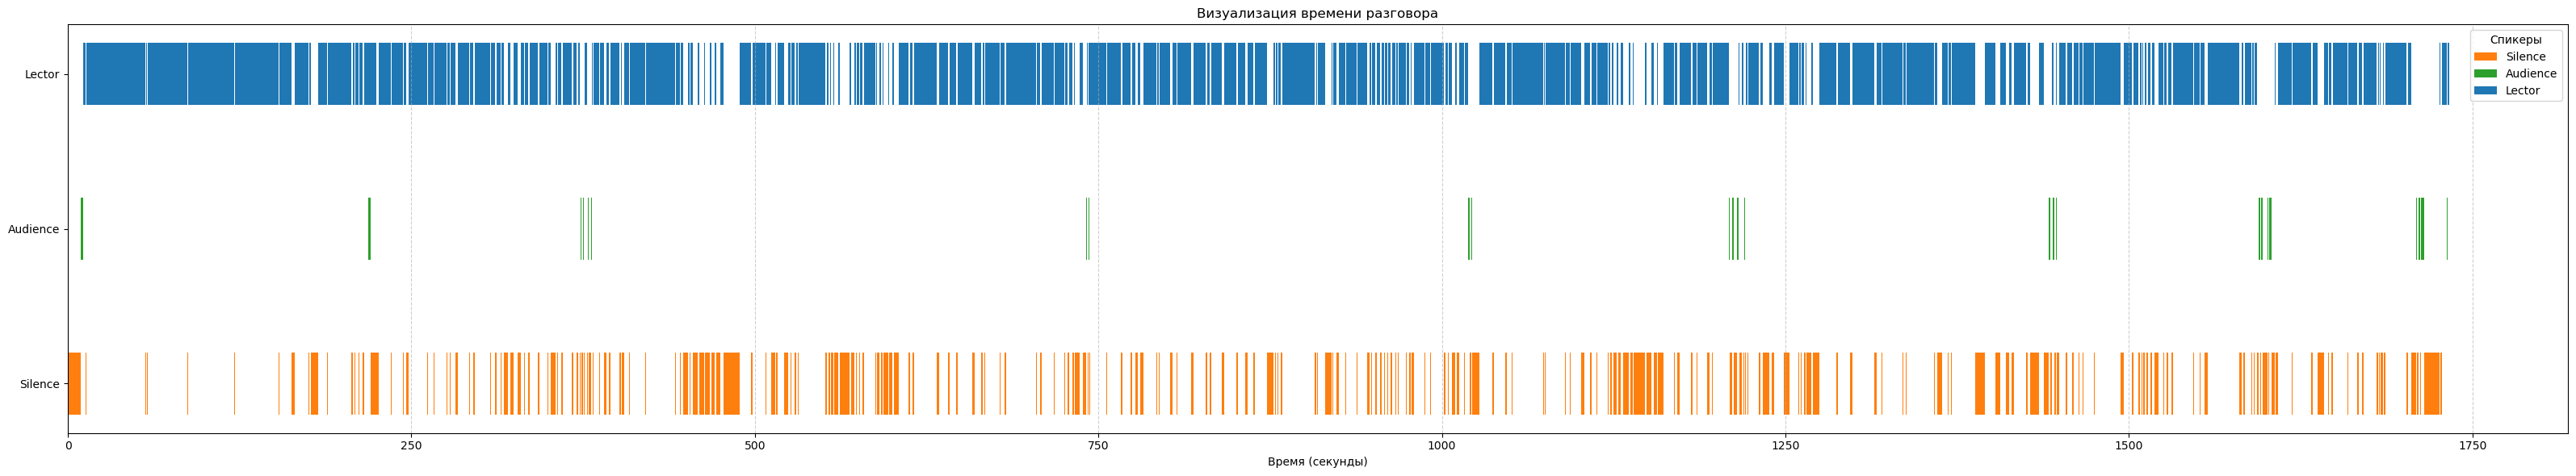

In [19]:
graphics(stat)